H = 0.5
W = 0.5
b = 0.05

Tw = 373
Ti = 303

eps = 0.9
g = 9.81
nu = 1.6e-05
k = 0.03

In [1]:
import shutil
import gmsh
import numpy as np
import pyvista as pv
import cfdtoolbox.foam as fu

pv.set_jupyter_backend("static")
pv.start_xvfb()

In [2]:
mesh_file = "meshes/foam-day-17-tutorial-01-natural-convection.msh2"

w = 0.50
h = 0.50
b = 0.05

nb = 10
nx = 50 - nb
ny = 50

In [3]:
gmsh.initialize()
gmsh.model.add("natcon")

In [4]:
_ = gmsh.model.geo.addPoint(0, 0, 0, tag=10)
_ = gmsh.model.geo.addPoint(b, 0, 0, tag=20)
_ = gmsh.model.geo.addPoint(w, 0, 0, tag=30)
_ = gmsh.model.geo.addPoint(0, h, 0, tag=11)
_ = gmsh.model.geo.addPoint(b, h, 0, tag=21)
_ = gmsh.model.geo.addPoint(w, h, 0, tag=31)

In [5]:
_ = gmsh.model.geo.addLine(10, 20, tag=10_20)
_ = gmsh.model.geo.addLine(20, 30, tag=20_30)
_ = gmsh.model.geo.addLine(30, 31, tag=30_31)
_ = gmsh.model.geo.addLine(31, 21, tag=31_21)
_ = gmsh.model.geo.addLine(21, 20, tag=21_20)
_ = gmsh.model.geo.addLine(21, 11, tag=21_11)
_ = gmsh.model.geo.addLine(11, 10, tag=11_10)

In [6]:
gmsh.model.geo.mesh.setTransfiniteCurve(10_20, nb, meshType='Progression', coef=1.0)
gmsh.model.geo.mesh.setTransfiniteCurve(21_11, nb, meshType='Progression', coef=1.0)

gmsh.model.geo.mesh.setTransfiniteCurve(20_30, nx, meshType='Progression', coef=1.0)
gmsh.model.geo.mesh.setTransfiniteCurve(31_21, nx, meshType='Progression', coef=1.0)

gmsh.model.geo.mesh.setTransfiniteCurve(11_10, ny, meshType='Progression', coef=1.0)
gmsh.model.geo.mesh.setTransfiniteCurve(21_20, ny, meshType='Progression', coef=1.0)
gmsh.model.geo.mesh.setTransfiniteCurve(30_31, ny, meshType='Progression', coef=1.0)

In [7]:
_ = gmsh.model.geo.addCurveLoop([10_20, 21_20, 21_11, 11_10], tag=1, reorient=True)
_ = gmsh.model.geo.addCurveLoop([20_30, 30_31, 31_21, 21_20], tag=2, reorient=True)

_ = gmsh.model.geo.addPlaneSurface([1], tag=1)
_ = gmsh.model.geo.addPlaneSurface([2], tag=2)

In [8]:
gmsh.model.geo.mesh.setTransfiniteSurface(1, arrangement='Left', cornerTags=[10, 20, 21, 11])
gmsh.model.geo.mesh.setTransfiniteSurface(2, arrangement='Left', cornerTags=[20, 30, 31, 21])

In [9]:
gmsh.model.geo.mesh.setRecombine(dim=2, tag=1, angle=45.0)
gmsh.model.geo.mesh.setRecombine(dim=2, tag=2, angle=45.0)

In [10]:
gmsh.model.geo.synchronize()

In [11]:
gmsh.model.geo.extrude(
    dimTags=[(1, 2)],
    dx=0.0,
    dy=0.0,
    dz=0.5,
    numElements=[1],
    heights=[0.5],
    recombine=True,
)

[]

In [12]:
?gmsh.model.geo.extrude

Signature:
gmsh.model.geo.extrude(
    dimTags,
    dx,
    dy,
    dz,
    numElements=[],
    heights=[],
    recombine=False,
)
Docstring:
gmsh.model.geo.extrude(dimTags, dx, dy, dz, numElements=[], heights=[], recombine=False)

Extrude the entities `dimTags' in the built-in CAD representation, using a
translation along (`dx', `dy', `dz'). Return extruded entities in
`outDimTags'. If `numElements' is not empty, also extrude the mesh: the
entries in `numElements' give the number of elements in each layer. If
`height' is not empty, it provides the (cumulative) height of the different
layers, normalized to 1. If `recombine' is set, recombine the mesh in the
layers.

Return `outDimTags'.
File:      /usr/local/lib/python3.9/site-packages/gmsh.py
Type:      function


In [13]:
gmsh.model.mesh.generate(dim=3)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1020 (Line)
Info    : [ 20%] Meshing curve 1110 (Line)
Info    : [ 30%] Meshing curve 2030 (Line)
Info    : [ 50%] Meshing curve 2111 (Line)
Info    : [ 60%] Meshing curve 2120 (Line)
Info    : [ 80%] Meshing curve 3031 (Line)
Info    : [ 90%] Meshing curve 3121 (Line)
Info    : Done meshing 1D (Wall 0.000278935s, CPU 0.000512s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 50%] Meshing surface 2 (Transfinite)
Info    : Done meshing 2D (Wall 0.000612322s, CPU 0s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 2.1066e-05s, CPU 0s)
Info    : 2450 nodes 2601 elements


In [14]:
gmsh.write(mesh_file)
gmsh.finalize()

Info    : Writing 'meshes/foam-day-17-tutorial-01-natural-convection.msh2'...
Info    : Done writing 'meshes/foam-day-17-tutorial-01-natural-convection.msh2'


In [15]:
old_mesh_file = str(mesh_file)
mesh_file = mesh_file[:-1]
shutil.move(old_mesh_file, mesh_file)

'meshes/foam-day-17-tutorial-01-natural-convection.msh'

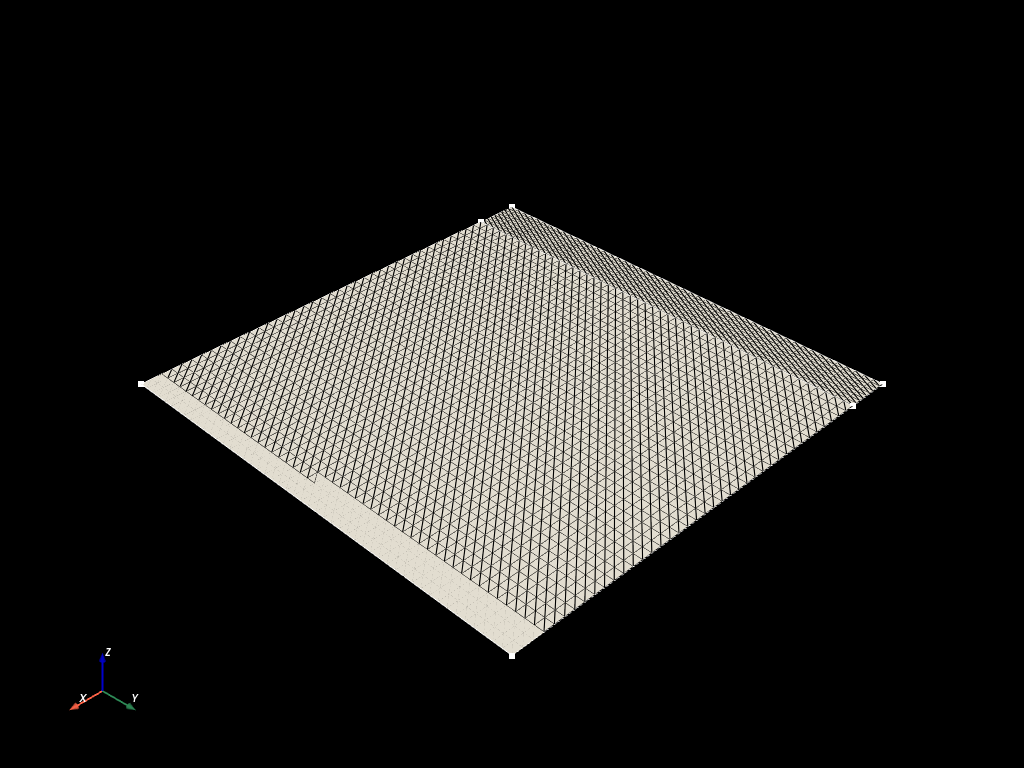

In [16]:
cpos = [(0.25, 0.2, 2.0),
        (0.25, 0.2, 0.0),
        (0.0, 0.0, 0.0)]

mtm = np.diag([2.8, 1.6, 1, 1])

fu.mesh.plot_mesh(mesh_file)#, cpos=cpos, mtm=mtm)

In [17]:

# # At this level, Gmsh knows everything to display the rectangular surface 1 and
# # to mesh it. An optional step is needed if we want to group elementary
# # geometrical entities into more meaningful groups, e.g. to define some
# # mathematical ("domain", "boundary"), functional ("left wing", "fuselage") or
# # material ("steel", "carbon") properties.
# #
# # Such groups are called "Physical Groups" in Gmsh. By default, if physical
# # groups are defined, Gmsh will export in output files only mesh elements that
# # belong to at least one physical group. (To force Gmsh to save all elements,
# # whether they belong to physical groups or not, set the `Mesh.SaveAll' option
# # to 1.) Physical groups are also identified by tags, i.e. stricly positive
# # integers, that should be unique per dimension (0D, 1D, 2D or 3D). Physical
# # groups can also be given names.
# #
# # Here we define a physical curve that groups the left, bottom and right curves
# # in a single group (with prescribed tag 5); and a physical surface with name
# # "My surface" (with an automatic tag) containing the geometrical surface 1:
# gmsh.model.addPhysicalGroup(1, [1, 2, 4], 5)
# ps = gmsh.model.addPhysicalGroup(2, [1])
# gmsh.model.setPhysicalName(2, ps, "My surface") 